In [1]:
# 导入需要的包
import paddle
import paddle.fluid as fluid
import numpy as np
from PIL import Image
import sys
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import os

C:\Users\czg\Anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\czg\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\czg\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


print(unpickle("./data/cifar-10-batches-py/data_batch_1").keys())
print(unpickle("./data/cifar-10-batches-py/test_batch").keys())

dict_keys([b'labels', b'data', b'batch_label', b'filenames'])
dict_keys([b'labels', b'data', b'batch_label', b'filenames'])


In [4]:
def test_mapper(sample):
    img, label = sample
    # 将img数组进行进行归一化处理，得到0到1之间的数值
    img = img.flatten().astype('float32') / 255.0
    return img, label

def train_mapper(sample):
    img, label = sample
    # 将img数组进行进行归一化处理，得到0到1之间的数值
    img = img.flatten().astype('float32') / 255.0
    return img, label

def train_r(buffered_size=1024):
    def reader():
        xs = []
        ys = []
        for i in range(1, 6):
            train_dict = unpickle("./data/cifar-10-batches-py/data_batch_%d" % (i,))
            xs.append(train_dict[b'data'])
            ys.append(train_dict[b'labels'])

        Xtr = np.concatenate(xs)
        Ytr = np.concatenate(ys)

        for (x, y) in zip(Xtr, Ytr):
            yield x, int(y)

    return paddle.reader.xmap_readers(train_mapper, reader, cpu_count(), buffered_size)

# 对自定义数据集创建训练集train的reader

def test_r(buffered_size=1024):
    def reader():
        test_dict = unpickle("./data/cifar-10-batches-py/test_batch")
        X = test_dict[b'data']
        Y = test_dict[b'labels']
        for (x, y) in zip(X, Y):
            yield x, int(y)
    return paddle.reader.xmap_readers(test_mapper, reader, cpu_count(), buffered_size)

In [5]:
BATCH_SIZE = 128
# 用于训练的数据提供器
train_reader = train_r()
train_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=train_reader, buf_size=128 * 100),
    batch_size=BATCH_SIZE)
# 用于测试的数据提供器
test_reader = test_r()
test_reader = paddle.batch(
    paddle.reader.shuffle(
        reader=test_reader, buf_size=300),
    batch_size=BATCH_SIZE)

In [6]:
def convolutional_neural_network(img):
    # 第一个卷积-池化层
    conv1 = fluid.layers.conv2d(input=img,  # 输入图像
                                num_filters=20,  # 卷积核大小
                                filter_size=5,  # 卷积核数量，它与输出的通道相同
                                act="relu")  # 激活函数
    pool1 = fluid.layers.pool2d(
        input=conv1,  # 输入
        pool_size=2,  # 池化核大小
        pool_type='max',  # 池化类型
        pool_stride=2)  # 池化步长
    conv_pool_1 = fluid.layers.batch_norm(pool1)

    # 第二个卷积-池化层
    conv2 = fluid.layers.conv2d(input=conv_pool_1,
                                num_filters=50,
                                filter_size=5,
                                act="relu")
    pool2 = fluid.layers.pool2d(
        input=conv2,
        pool_size=2,
        pool_type='max',
        pool_stride=2,
        global_pooling=False)
    conv_pool_2 = fluid.layers.batch_norm(pool2)
    # 第三个卷积-池化层
    conv3 = fluid.layers.conv2d(input=conv_pool_2, num_filters=50, filter_size=5, act="relu")
    pool3 = fluid.layers.pool2d(
        input=conv3,
        pool_size=2,
        pool_type='max',
        pool_stride=2,
        global_pooling=False)
    # 以softmax为激活函数的全连接输出层，10类数据输出10个数字
    prediction = fluid.layers.fc(input=pool3,
                                 size=10,
                                 act='softmax')
    return prediction

In [7]:
# 定义输入数据
data_shape = [3, 32, 32]
images = fluid.layers.data(name='images', shape=data_shape, dtype='float32')
label = fluid.layers.data(name='label', shape=[1], dtype='int64')

# 获取分类器，用cnn进行分类
predict = convolutional_neural_network(images)

# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=predict, label=label)  # 交叉熵
avg_cost = fluid.layers.mean(cost)  # 计算cost中所有元素的平均值
acc = fluid.layers.accuracy(input=predict, label=label)  # 使用输入和标签计算准确率

# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)
# 定义优化方法
optimizer = fluid.optimizer.Adam(learning_rate=0.001)
optimizer.minimize(avg_cost)
print("完成")

完成


In [8]:
# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

feeder = fluid.DataFeeder(feed_list=[images, label], place=place)

all_train_iter = 0
all_train_iters = []
all_train_costs = []
all_train_accs = []


def draw_train_process(title, iters, costs, accs, label_cost, lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs, color='red', label=label_cost)
    plt.plot(iters, accs, color='green', label=lable_acc)
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
EPOCH_NUM = 1
model_save_dir = "./catdog.inference.model"

for pass_id in range(EPOCH_NUM):
    # 开始训练
    for batch_id, data in enumerate(train_reader()):  # 遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),  # 运行主程序
                                        feed=feeder.feed(data),  # 喂入一个batch的数据
                                        fetch_list=[avg_cost, acc])  # fetch均方误差和准确率

        all_train_iter = all_train_iter + BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])

        # 每100次batch打印一次训练、进行一次测试
        if batch_id % 20 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # 开始测试
    test_costs = []  # 测试的损失值
    test_accs = []  # 测试的准确率
    for batch_id, data in enumerate(test_reader()):
        test_cost, test_acc = exe.run(program=test_program,  # 执行训练程序
                                      feed=feeder.feed(data),  # 喂入数据
                                      fetch_list=[avg_cost, acc])  # fetch 误差、准确率
        test_costs.append(test_cost[0])  # 记录每个batch的误差
        test_accs.append(test_acc[0])  # 记录每个batch的准确率

    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))  # 计算误差平均值（误差和/误差的个数）
    test_acc = (sum(test_accs) / len(test_accs))  # 计算准确率平均值（ 准确率的和/准确率的个数）
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))

Pass:0, Batch:0, Cost:2.82002, Accuracy:0.08594
Pass:0, Batch:20, Cost:1.83462, Accuracy:0.39062
Pass:0, Batch:40, Cost:1.83181, Accuracy:0.39062
Pass:0, Batch:60, Cost:1.87479, Accuracy:0.33594
Pass:0, Batch:80, Cost:1.59112, Accuracy:0.40625
Pass:0, Batch:100, Cost:1.44504, Accuracy:0.52344
Pass:0, Batch:120, Cost:1.48817, Accuracy:0.40625
Pass:0, Batch:140, Cost:1.47978, Accuracy:0.50000
Pass:0, Batch:160, Cost:1.57265, Accuracy:0.42969
Pass:0, Batch:180, Cost:1.48635, Accuracy:0.42969
Pass:0, Batch:200, Cost:1.58953, Accuracy:0.48438
Pass:0, Batch:220, Cost:1.49139, Accuracy:0.46094
Pass:0, Batch:240, Cost:1.42805, Accuracy:0.48438
Pass:0, Batch:260, Cost:1.43389, Accuracy:0.50781
Pass:0, Batch:280, Cost:1.37230, Accuracy:0.46875
Pass:0, Batch:300, Cost:1.33001, Accuracy:0.54688
Pass:0, Batch:320, Cost:1.16739, Accuracy:0.60156
Pass:0, Batch:340, Cost:1.17318, Accuracy:0.60156
Pass:0, Batch:360, Cost:1.08149, Accuracy:0.57812
Pass:0, Batch:380, Cost:1.34651, Accuracy:0.54688
Test:0

save models to ./catdog.inference.model
训练模型保存完成！


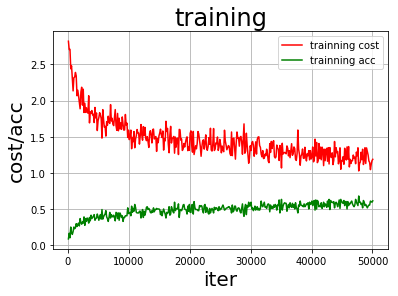

In [10]:
# 保存模型
# 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,
                              ['images'],
                              [predict],
                              exe)
print('训练模型保存完成！')
draw_train_process("training", all_train_iters, all_train_costs, all_train_accs, "trainning cost", "trainning acc")

In [11]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

def load_image(file):
    # 打开图片
    im = Image.open(file)
    # 将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
    im = im.resize((32, 32), Image.ANTIALIAS)
    # 建立图片矩阵 类型为float32
    im = np.array(im).astype(np.float32)
    # 矩阵转置
    im = im.transpose((2, 0, 1))
    # 将像素值从【0-255】转换为【0-1】
    im = im / 255.0
    # print(im)
    im = np.expand_dims(im, axis=0)
    # 保持和之前输入image维度一致
    print('im_shape的维度：', im.shape)
    return im

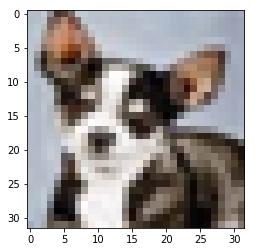

im_shape的维度： (1, 3, 32, 32)
results [array([[0.21010092, 0.0153084 , 0.08519617, 0.22988823, 0.01993718,
        0.15378426, 0.02756022, 0.18605247, 0.00540622, 0.06676589]],
      dtype=float32)]
infer results: cat


In [12]:
with fluid.scope_guard(inference_scope):
    # 从指定目录中加载 推理model(inference model)
    [inference_program,  # 预测用的program
     feed_target_names,  # 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,  # fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。
                                                    infer_exe)  # infer_exe: 运行 inference model的 executor

    infer_path = './data/dog.png'
    img = Image.open(infer_path)
    plt.imshow(img)
    plt.show()

    img = load_image(infer_path)

    results = infer_exe.run(inference_program,  # 运行预测程序
                            feed={feed_target_names[0]: img},  # 喂入要预测的img
                            fetch_list=fetch_targets)  # 得到推测结果
    print('results', results)
    label_list = [
        "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
        "ship", "truck"
    ]
    print("infer results: %s" % label_list[np.argmax(results[0])])